In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os
import feather
from sklearn.pipeline import make_pipeline
from sktime.datasets import load_from_tsfile_to_dataframe
sns.set(style="whitegrid")

--------------------------------------

### Preparing the frames to store information

In [6]:
# row corresponds to classifier, col to dataset
accuracy = pd.DataFrame(columns=datasets)

In [7]:
classifiers = ['KN_sktime', 
               'KN_sumCl', 
               'KN_sklearn', 
               'KN_catch22',
               'KN_kats',
               'KN_tsfeatures',
               'KN_tsfel',
               'KN_tsfresh']

Adiac_pred        = pd.DataFrame(columns=classifiers)
Fish_pred         = pd.DataFrame(columns=classifiers)
OliveOil_pred     = pd.DataFrame(columns=classifiers)
Phoneme_pred      = pd.DataFrame(columns=classifiers)
ShapesAll_pred    = pd.DataFrame(columns=classifiers)
SwedishLeaf_pred  = pd.DataFrame(columns=classifiers)
WordSynonyms_pred = pd.DataFrame(columns=classifiers)

predictionFrames = [Adiac_pred,
                    Fish_pred,
                    OliveOil_pred,
                    Phoneme_pred,
                    ShapesAll_pred,
                    SwedishLeaf_pred,
                    WordSynonyms_pred]

--------------------------------------

### Starting with SKTIME

In [8]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sktime.classification.feature_based import SummaryClassifier

sktime_classifier  = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance="euclidean")
sklearn_classifier = KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski')
sc_clasifier       = SummaryClassifier(estimator=sklearn_classifier)

In [52]:
Adiac_pred

,KN_sktime,KN_sumCl,KN_sklearn,KN_catch22,KN_kats,KN_tsfeatures,KN_tsfel,KN_tsfresh
0,36,16,36,NaN,NaN,NaN,NaN,NaN
1,36,36,36,NaN,NaN,NaN,NaN,NaN
2,28,34,28,NaN,NaN,NaN,NaN,NaN
3,32,32,32,NaN,NaN,NaN,NaN,NaN
4,12,16,12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
386,25,25,25,NaN,NaN,NaN,NaN,NaN
387,35,22,35,NaN,NaN,NaN,NaN,NaN
388,7,22,7,NaN,NaN,NaN,NaN,NaN
389,36,36,36,NaN,NaN,NaN,NaN,NaN


In [9]:
score1 = []
score2 = []

for dataset, i in zip(datasets, range(len(predictionFrames))):
    
    print(dataset)
    
    # load training data
    X_train, y_train = load_from_tsfile_to_dataframe('data/' + dataset + '_TRAIN.ts')

    # load test data
    X_test, y_test = load_from_tsfile_to_dataframe('data/' + dataset + '_TEST.ts')
    
    ######################
    # sktime - KNeighbours
    
    sktime_classifier.fit(X_train, y_train)
    score1.append(sktime_classifier.score(X_test, y_test))
    predictionFrames[i]['KN_sktime'] = sktime_classifier.predict(X_test)

Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms


In [14]:
score2 = []

for dataset, i in zip(datasets, range(len(predictionFrames))):
    # load training data
    X_train, y_train = load_from_tsfile_to_dataframe('data/' + dataset + '_TRAIN.ts')

    # load test data
    X_test, y_test = load_from_tsfile_to_dataframe('data/' + dataset + '_TEST.ts')
    
    ############################
    # sktime - SummaryClassifier
    
    if dataset == 'Phoneme':
        score2.append(np.nan)
        continue
    else:
        sc_clasifier.fit(X_train, y_train)
        score2.append(sc_clasifier.score(X_test, y_test))
        predictionFrames[i]['KN_sumCl'] = sc_clasifier.predict(X_test)

Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms


In [15]:
accuracy.loc[0] = score1
accuracy.loc[1] = score2

In [16]:
accuracy

,Adiac,Fish,OliveOil,Phoneme,ShapesAll,SwedishLeaf,WordSynonyms
0,0.542199,0.754286,0.900000,0.096519,0.685000,0.7296,0.565831
1,0.616368,0.474286,0.566667,NaN,0.446667,0.6256,0.208464


--------------------------------------

### SKLEARN - basic

In [21]:
def getFrame(dataset, labels):
    
    # stores series 
    finalFrame = pd.DataFrame()
    
    for row in dataset.iterrows():
        finalFrame = pd.concat([finalFrame, row[1].values[0].to_frame().T], ignore_index=True)
    
    # adds labels at the end of the frame
    finalFrame['label'] = [int(i) for i in labels]

    return finalFrame

In [28]:
score3 = []

for dataset, i in zip(datasets, range(len(predictionFrames))):
    
    # load training data
    X_train, y_train = load_from_tsfile_to_dataframe('data/' + dataset + '_TRAIN.ts')
    trainData = getFrame(X_train, y_train)

    # load test data
    X_test, y_test = load_from_tsfile_to_dataframe('data/' + dataset + '_TEST.ts')
    testData = getFrame(X_test, y_test)
    
    sklearn_classifier.fit(trainData.iloc[:, :-1], trainData['label'])
    score3.append(sklearn_classifier.score(testData.iloc[:, :-1], testData['label']))
    predictionFrames[i]['KN_sklearn'] = sklearn_classifier.predict(testData.iloc[:, :-1])

Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms


In [29]:
accuracy.loc[2] = score3
accuracy

,Adiac,Fish,OliveOil,Phoneme,ShapesAll,SwedishLeaf,WordSynonyms
0,0.542199,0.754286,0.900000,0.096519,0.685000,0.7296,0.565831
1,0.616368,0.474286,0.566667,NaN,0.446667,0.6256,0.208464
2,0.552430,0.754286,0.900000,0.103376,0.690000,0.7184,0.567398


--------------------------------------

### SKLEARN x Features

In [54]:
j = 3
for ex, name in zip(extractors, classifiers[-5:]) :
    scoreX = []
    
    for dataset, i in zip(datasets, range(len(predictionFrames))):
        
        train = ex.loc[(ex['data'] == dataset) & (ex['set'] == 'train')]
        test  = ex.loc[(ex['data'] == dataset) & (ex['set'] == 'test')]
        
        sklearn_classifier.fit(train.iloc[:, :-3], train['label'])
        scoreX.append(sklearn_classifier.score(test.iloc[:, :-3], test['label']))
        
        pred = sklearn_classifier.predict(test.iloc[:, :-3])
        
        if len(pred) == len(predictionFrames[i][name]):
            predictionFrames[i][name] = pred
        else:
            continue
        
    accuracy.loc[j] = scoreX
    j += 1

KN_catch22
Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms
KN_kats
Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms
KN_tsfeatures
Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms
KN_tsfel
Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms
KN_tsfresh
Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms


In [57]:
accuracy

,Adiac,Fish,OliveOil,Phoneme,ShapesAll,SwedishLeaf,WordSynonyms
0,0.542199,0.754286,0.900000,0.096519,0.685000,0.729600,0.565831
1,0.616368,0.474286,0.566667,NaN,0.446667,0.625600,0.208464
2,0.552430,0.754286,0.900000,0.103376,0.690000,0.718400,0.567398
3,0.355499,0.508571,0.366667,0.154008,0.430000,0.699200,0.300940
4,0.268542,0.445714,0.300000,0.166667,0.311667,0.601600,0.354232
5,0.430052,0.371429,0.633333,0.149213,0.382906,0.669903,0.385466
6,0.337596,0.245714,0.566667,0.073312,0.140000,0.526400,0.230408
7,0.017903,0.102857,0.300000,0.063358,0.013333,0.068800,0.135433


--------------------------------------

### Plotting accuracy

#### Plot for each dataset

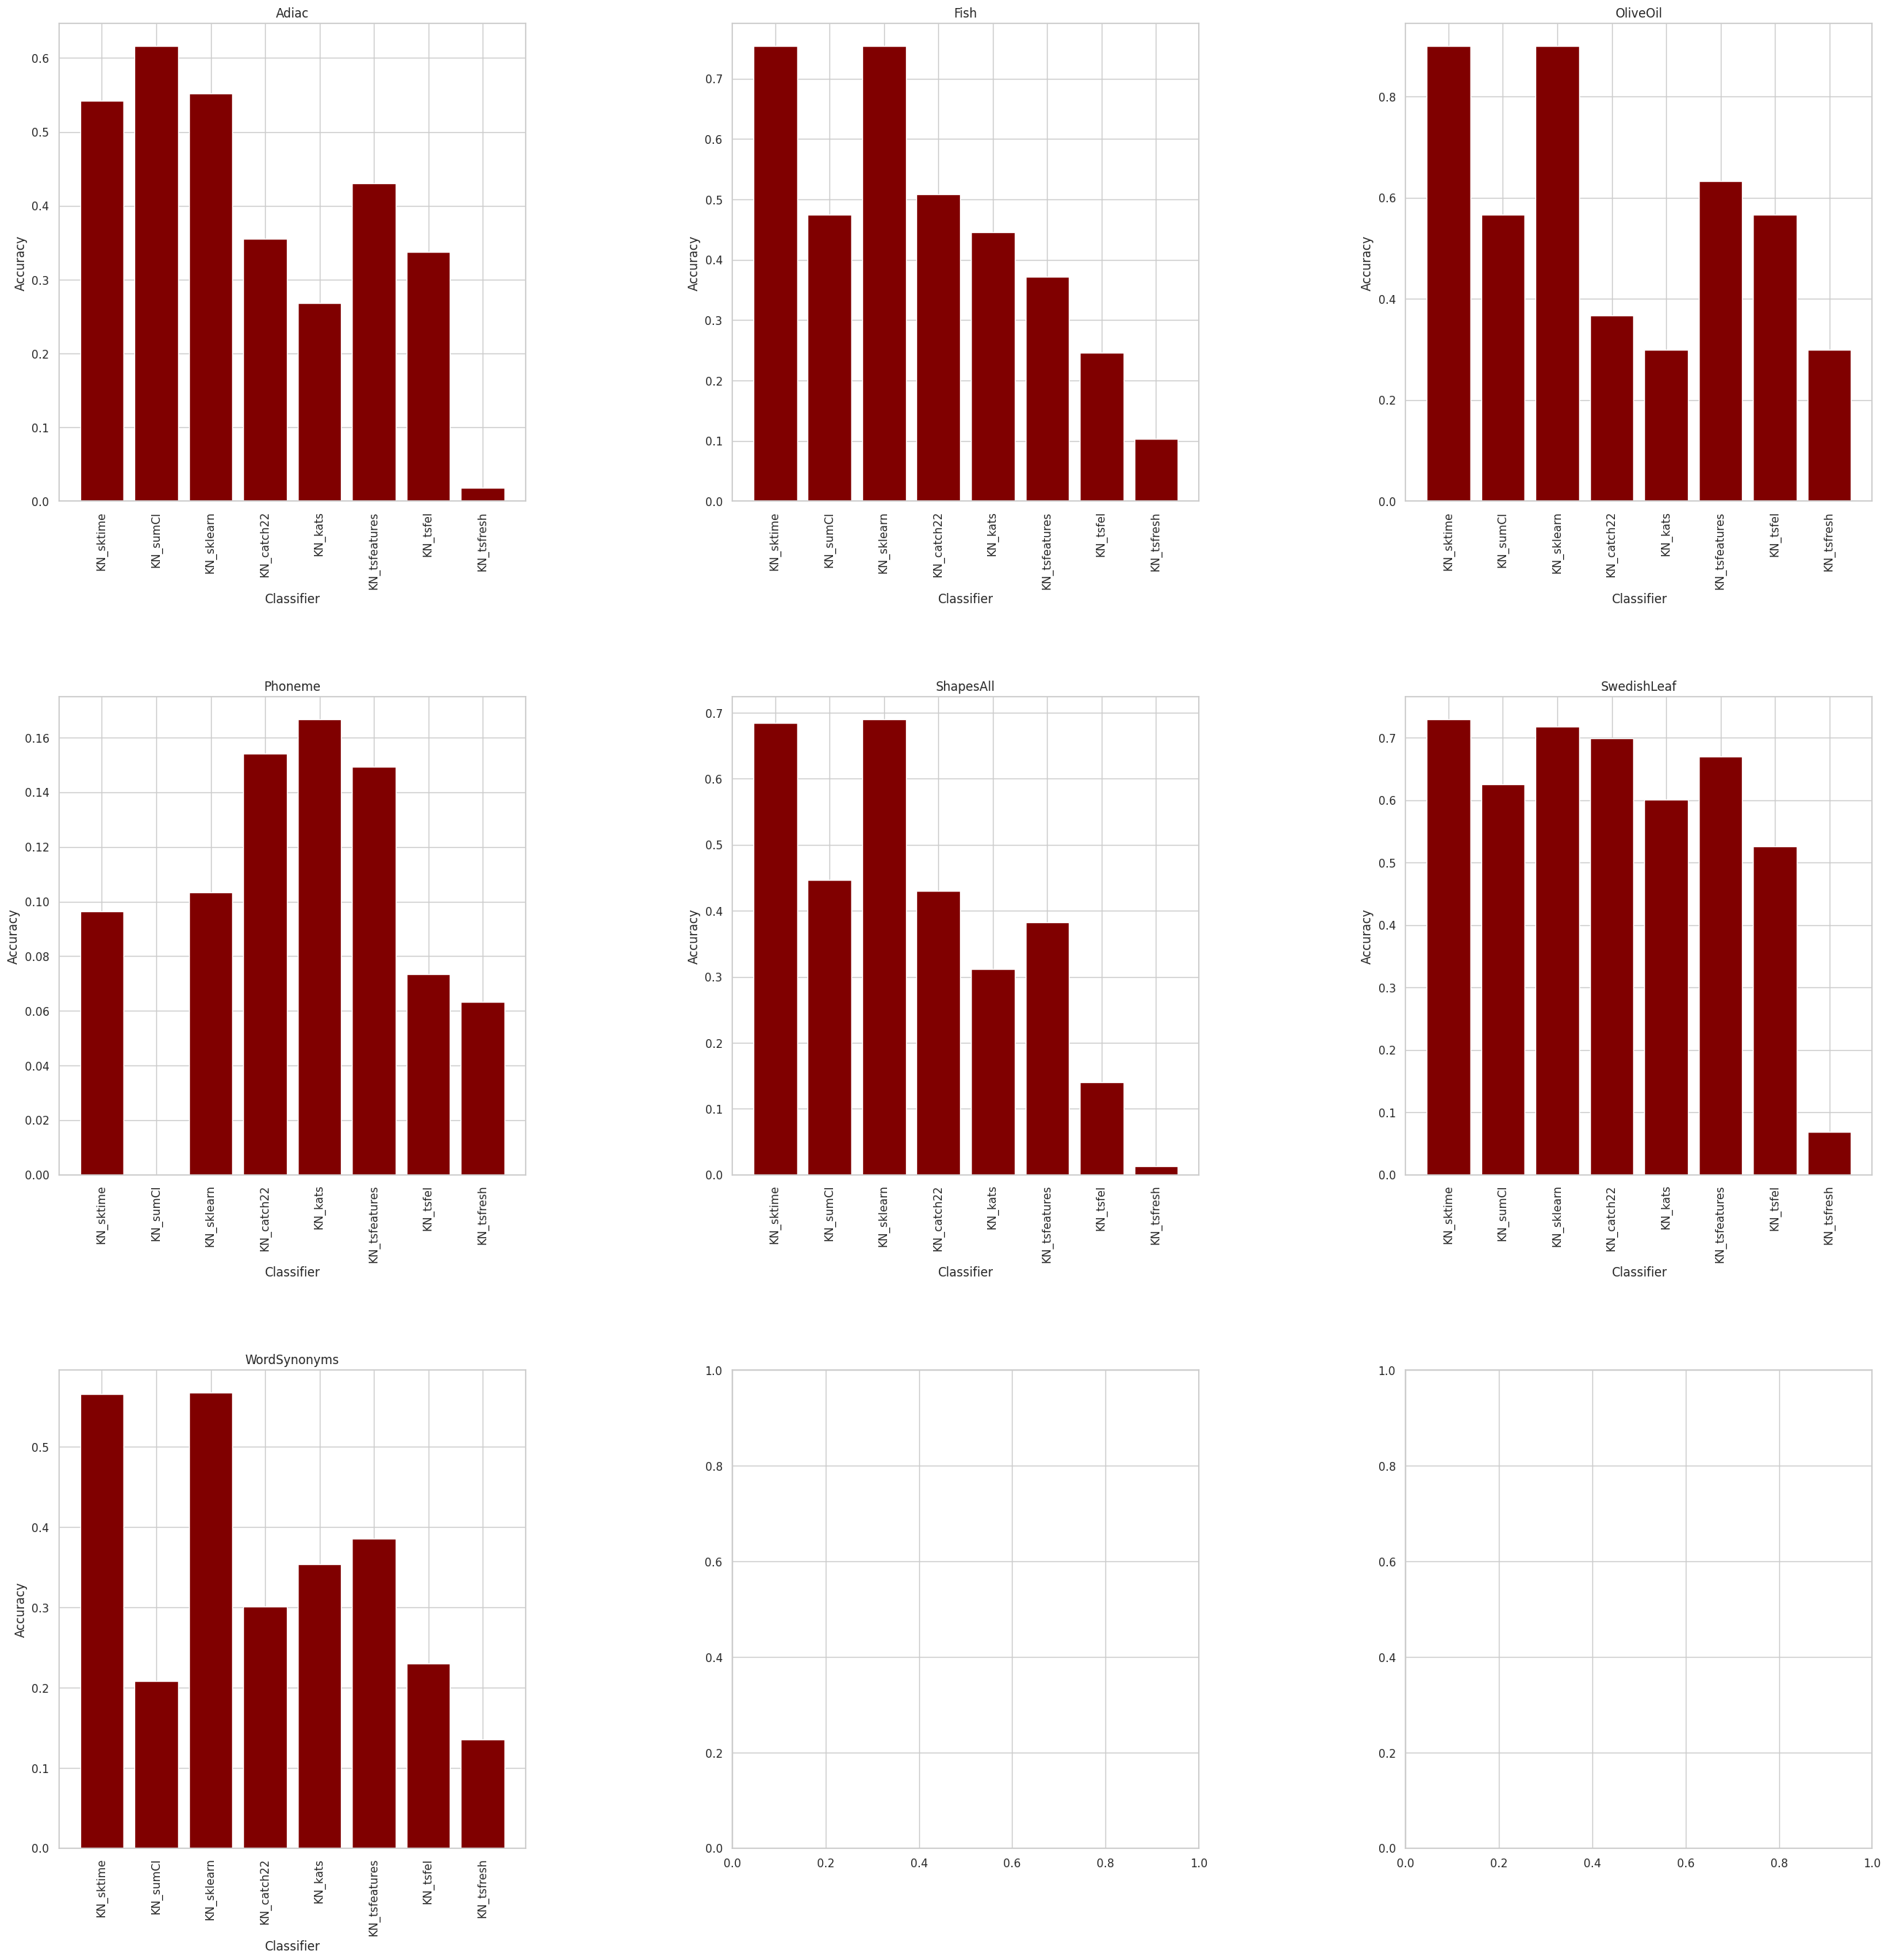

In [91]:
plotAccuracy(accuracy, classifiers, True)

#### Plot for each classifier

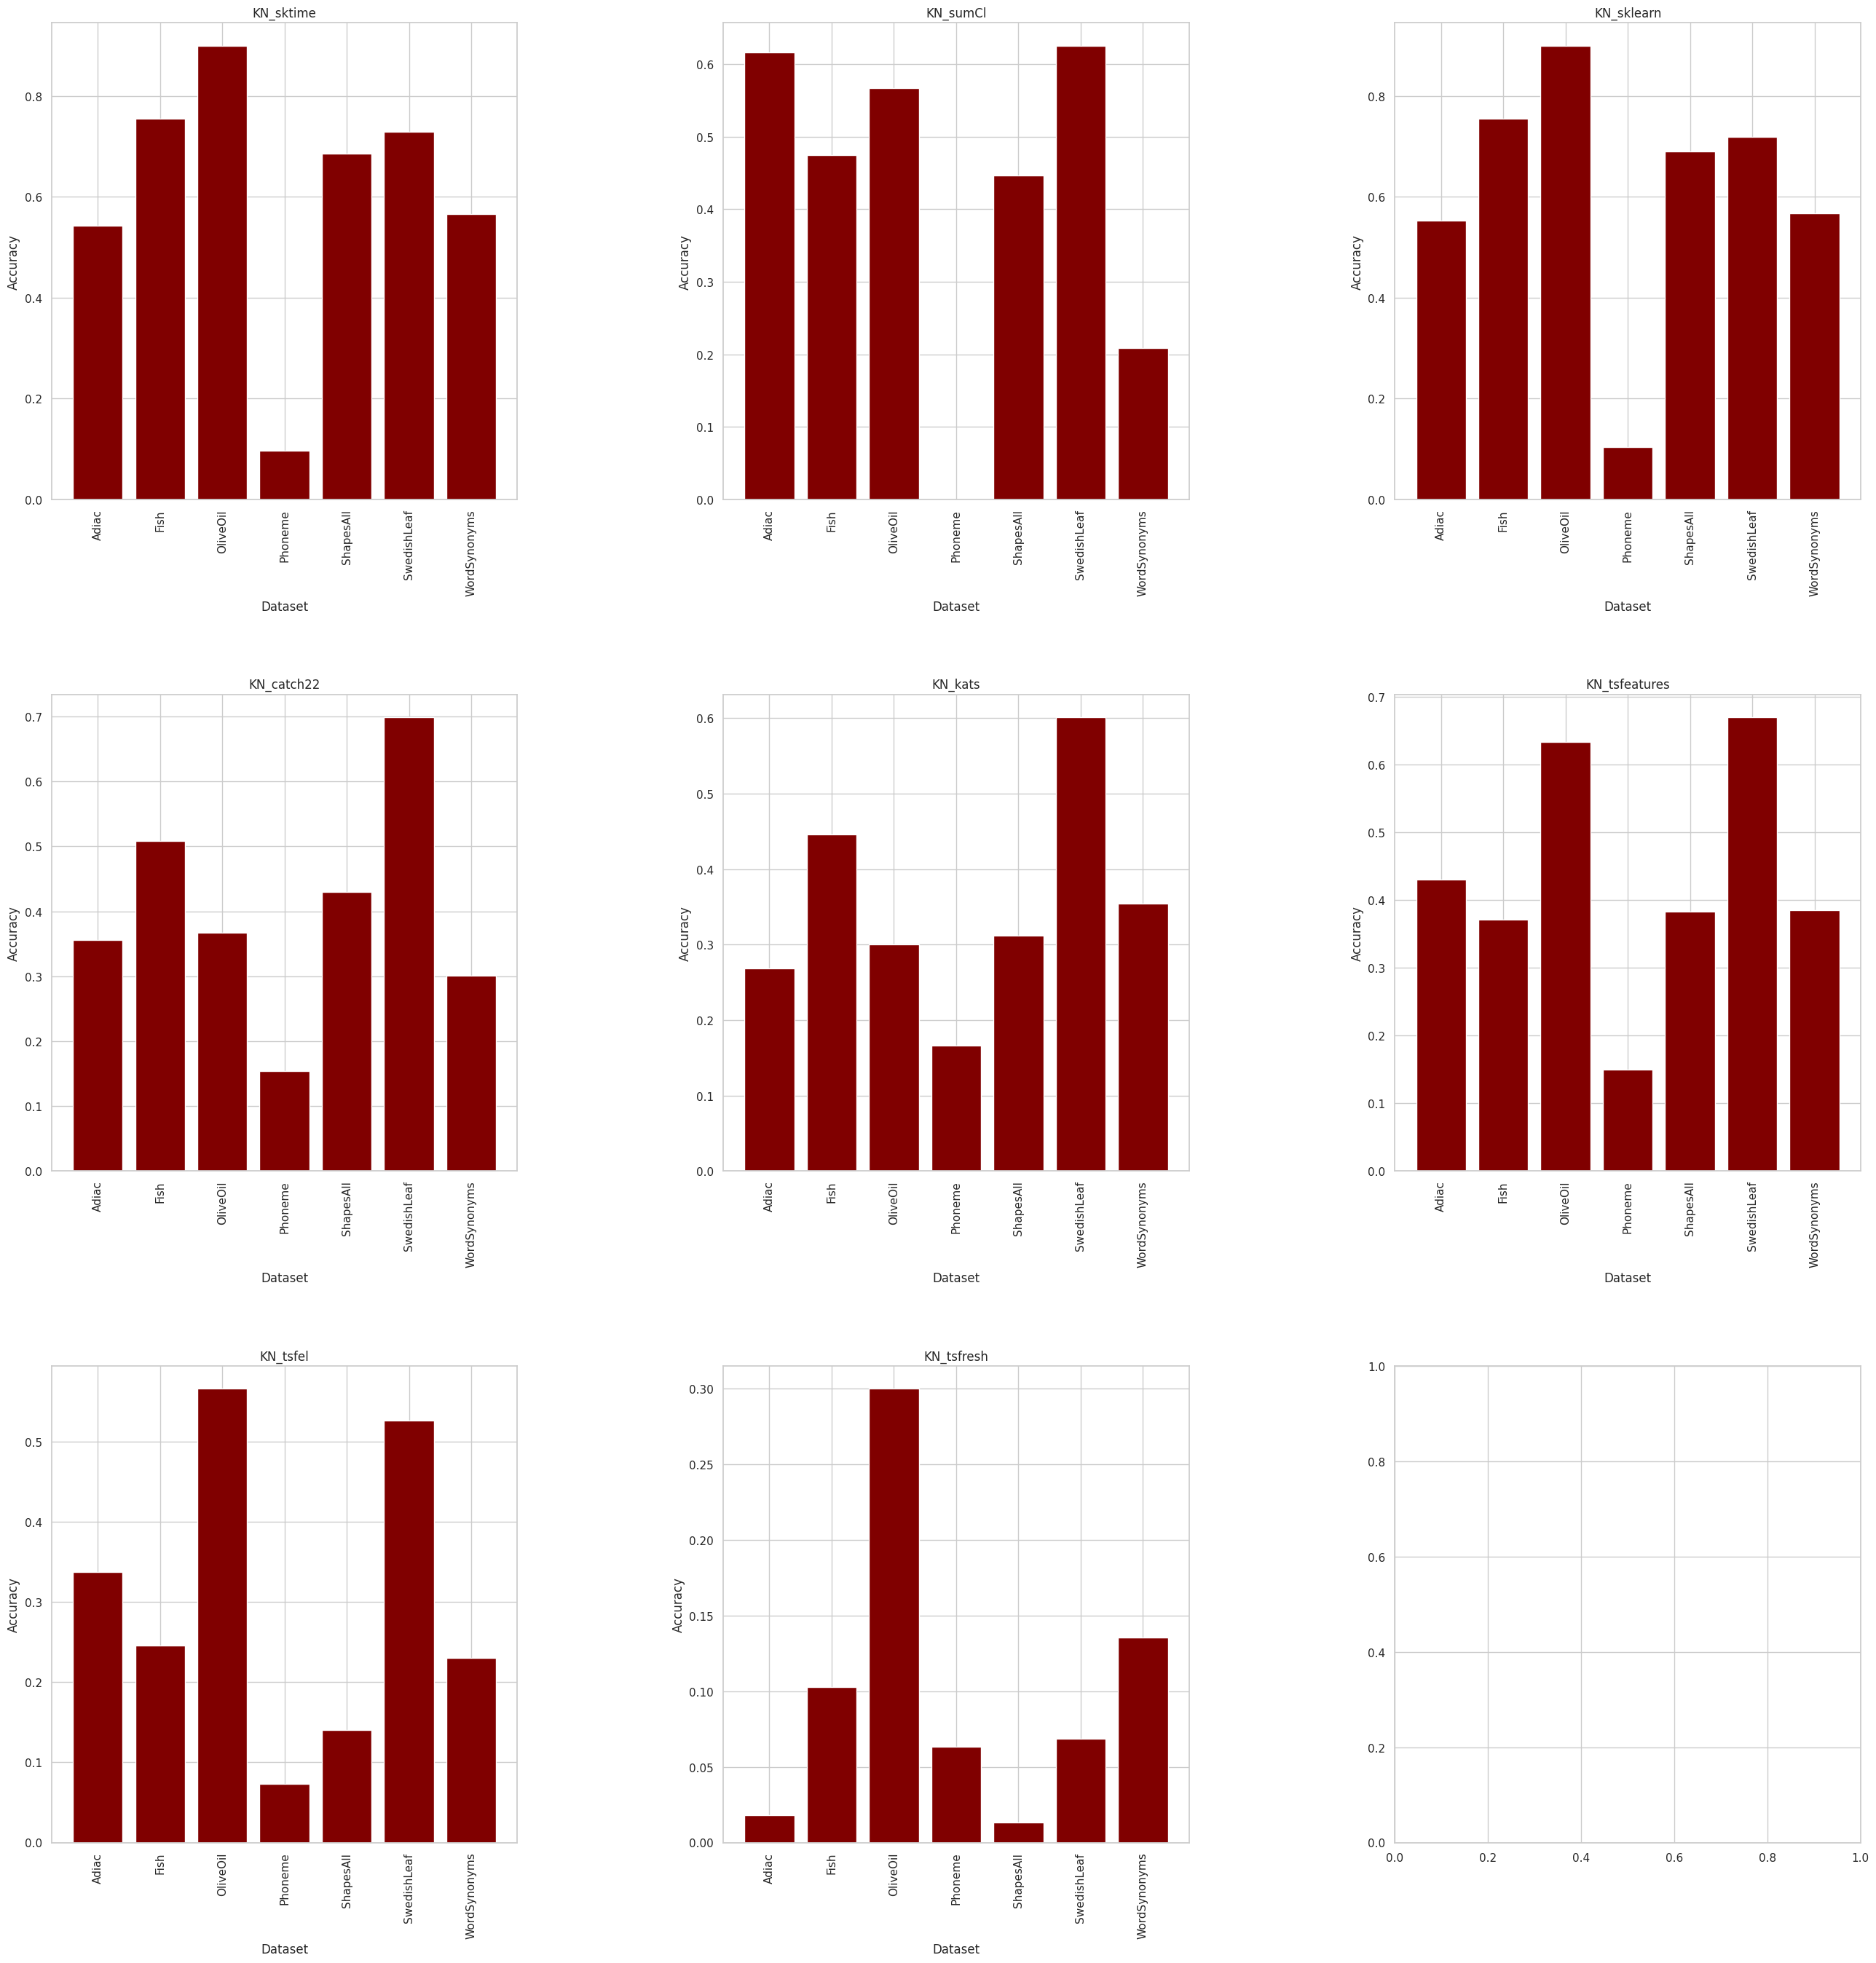

In [92]:
plotAccuracy(accuracy, classifiers, False)

--------------------------------------